In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os
import re
import os.path
from os import path

In [ ]:
from definitions import *

In [ ]:
FWHM_factor = 2 * np.sqrt(2 * np.log(2))
def alpha_fun(delta_B, theta_0):
    return c * delta_B / (np.pi * np.tan(theta_0))

def I_envelope(y, delta_B, theta_0, wl_sigma):
    alpha = alpha_fun(delta_B, theta_0)
    E_y = np.exp(-0.5 * (2 * np.pi * alpha * wl_sigma * y) ** 2)
    return E_y
def I_empty_analytical(y, lambda_0, delta_B, theta_0, wl_sigma, up = True):
    E_y = I_envelope(y, delta_B, theta_0, wl_sigma)
    alpha = alpha_fun(delta_B, theta_0)
    # mod = np.cos(2 * np.pi * alpha * lambda_0 * y)
    p_0 = compute_p_0(delta_B, lambda_0, theta_0)
    # print(p_0)
    mod = np.cos(2 * np.pi * lambda_0 * alpha * y)
    # print(alpha * lambda_0 * y)
    # print(mod)
    if up:
        return mod * E_y
    else:
        return -mod * E_y
y = np.linspace(-0.005, 0.005, 1000)

for (folder, theta_0_deg) in [('foil_data', 5.5), ('iwsp_data', 45), ('iso_data', 20)]:
    i = 1
    y, I_up, I_down, I_empty_up, I_empty_down, By = get_data(i, folder=folder)
    print(f"Measurement {i}; By = {By}")
    y*=1e1  
    lambda_0 = 2.165e-10
    # By = 0.00625
    theta_0 = np.deg2rad(theta_0_deg)
    # I_0 = 0.45e-9
    I = I_empty_up
    indices = indices_within_range(y * 1e-3, -0.0049, 0.0049)
    def I_fit(y, I_0):
        return I_empty_analytical(y * 1e-3, lambda_0, By, theta_0, wl_sigma=0.1e-10) * I_0 + I_0
    popt, pcov = curve_fit(I_fit, y[indices], I[indices])
    print(popt, pcov)
    I_0 = popt[0]
    dI_0 = pcov[0][0]
    print(I_0, dI_0)
    
    E_y = I_empty_analytical(y * 1e-3, lambda_0, By, theta_0, wl_sigma=0.1e-10) * I_0 + I_0
    p_0 = compute_p_0(By, lambda_0, theta_0)
    # plt.axvline(p_0 * 1e3, linestyle='--', color='r')
    plt.scatter(y, I_empty_up,s=5,  label='Up, empty', color='green')
    plt.plot(y, E_y, linestyle='--', label='Up, empty analytical')
    # plt.scatter(y, I_empty_down, s=2, label='Down, empty')
    plt.xlabel('y [mm]')
    plt.ylabel('I')
    plt.title(r'$I_{up,empty}$, ' + folder)
    plt.grid()
    plt.legend()
    plt.show()

In [ ]:
plt.scatter(y, I_up,s=2,  label='Up')
plt.scatter(y, I_down,s=2, label='Down')
plt.xlabel('y [mm]')
plt.ylabel('I')
plt.title('PSD intensity')
plt.grid()
plt.legend()
plt.show()

In [ ]:
import numpy.fft as fft
def plot_spectra(Is):
    indices = indices_within_range(y, -4.85, 4.85)
    N = len(indices)
    d = (y[1] - y[0])*1e-3
    f = fft.fftshift(fft.fftfreq(N, d=d))
    for I in Is:
        I_spectrum = fft.fftshift(np.abs(fft.fft(I[indices])))/N
        plt.plot(f,I_spectrum)
    f_max = 5000
    plt.xlim((-f_max,f_max))
    plt.grid()
    plt.show()
plot_spectra([I_up])
plot_spectra([I_empty_up])

In [ ]:

plot_spectra([I_up, I_down, I_empty_up, I_empty_down])
plot_spectra([I_up,I_empty_up - I_up])

In [ ]:
def compute_P_dark_field(I_up,I_down):
    return  (I_up - I_down) / (I_up + I_down)

P_s = compute_P_dark_field(I_up,I_down)
P_b = compute_P_dark_field(I_empty_up,I_empty_down)

plt.plot(y, P_s,'-',  label='Sample, analyzer')
plt.plot(y,P_b, label='No sample, analyzer')
plt.xlabel('y [mm]')

E_y = I_empty_analytical(y * 1e-3, lambda_0, By, theta_0, wl_sigma=0.1e-10)
p_0 = compute_p_0(By, lambda_0, theta_0)
plt.plot(y, E_y)
plt.axvline(p_0 * 1e3, linestyle='--', color='r')

plt.ylabel('P')
plt.title('PSD intensity')
plt.grid()
plt.legend()
plt.show()

# Polarization curves

In [ ]:
def compute_P(I_up,I_down, dI_up, dI_down):
    P = (I_up - I_down) / (I_up + I_down)
    dP = 2 * np.sqrt((I_down * dI_up)**2 + (I_up * dI_down)**2) / (I_up + I_down) ** 2 
    return P, dP

def compute_rms(x, dx):
    rms = np.sqrt(np.mean(np.square(x)))
    squared_errors = np.square(dx)
    mean_squared_values = np.mean(np.square(x))
    d_rms = np.sqrt(np.sum(squared_errors) / (2 * len(x) * mean_squared_values))
    return rms, d_rms 

def get_measurement_point(i, folder='data'):
    d1 = np.genfromtxt(f'{folder}/up/{i}/det.dat', delimiter=' ', usecols=(0,1,2,3), unpack=True)
    d2 = np.genfromtxt(f'{folder}/down/{i}/det.dat', delimiter=' ', usecols=(0,1,2,3), unpack=True)
    d3 = np.genfromtxt(f'{folder}/empty_up/{i}/det.dat', delimiter=' ', usecols=(0,1,2,3), unpack=True)
    d4 = np.genfromtxt(f'{folder}/empty_down/{i}/det.dat', delimiter=' ', usecols=(0,1,2,3), unpack=True)
    up = DetectorReading(*d1)
    down = DetectorReading(*d2)
    empty_up = DetectorReading(*d3)
    empty_down = DetectorReading(*d4)
    parameters = extract_parameters(f'{folder}/up/{i}/det.dat')
    mp = MeasurementPoint(up, down, empty_up, empty_down, parameters)
    return mp
    

class DetectorReading:
    def __init__(self, y, I, I_err, N):
        self.y = y * 10
        self.I = I
        self.dI = I_err
        self.N = N

class MeasurementPoint:
    def __init__(self, up, down, empty_up, empty_down, parameters):
        self.up = up
        self.down = down
        self.empty_up = empty_up
        self.empty_down = empty_down
        self.parameters = parameters
    
    def y(self):
        return self.up.y
    
    def compute_P(self):
        P_s, dP_s = compute_P(self.up.I, self.down.I, self.up.dI, self.down.dI)
        P_b, dP_b = compute_P(self.empty_up.I, self.empty_down.I, self.empty_up.dI, self.empty_down.dI)
        return self.y(), P_b, dP_b, P_s, dP_s
    
    def compute_rms(self, y_range = None):
        y, P_b, dP_b, P_s, dP_s = self.compute_P()
        if y_range == None:
            rms_b, d_rms_b = compute_rms(P_b, dP_b)
            rms_s, d_rms_s = compute_rms(P_s, dP_s)
        else:
            # range is assumed to be of the form (y_min, y_max)
            indices = indices_within_range(y, *y_range)
            rms_b, d_rms_b = compute_rms(P_b[indices], dP_b[indices])
            rms_s, d_rms_s = compute_rms(P_s[indices], dP_s[indices])
        return rms_b, d_rms_b, rms_s, d_rms_s

    def rms_ratio(self, y_range = None):
        rms_b, d_rms_b, rms_s, d_rms_s = self.compute_rms(y_range=y_range)
        R = rms_s / rms_b
        dR = np.sqrt((d_rms_s / rms_b)**2 + (rms_s * d_rms_b / rms_b**2)**2)
        return R, dR
    
    def plot_intensities(self):
        plt.plot(self.y(), self.empty_up.I, label='Up')
        plt.plot(self.y(), self.empty_down.I, label = 'Down')
        plt.title(r'Base $I_{up}, I_{down}$')
        plt.grid()
        plt.legend()
        plt.show()    
        plt.plot(self.y(), self.up.I, label='Up')
        plt.plot(self.y(), self.down.I, label = 'Down')
        plt.title(r'Sample $I_{up}, I_{down}$')
        plt.grid()
        plt.legend()
        plt.show()
    


In [ ]:
x = get_measurement_point(4, 'foil_data')
y, P_b, dP_b, P_s, dP_s = x.compute_P()
y_range=(-4.5,4.5)
rms_b, d_rms_b, rms_s, d_rms_s = x.compute_rms(y_range)
print(rms_b, d_rms_b, rms_s, d_rms_s)
R, dR = x.rms_ratio(y_range)
print(R, dR)
# print(P, dP)
plt.plot(y,P_b)
plt.plot(y,P_s)
plt.show()
# plt.errorbar(y,P, linestyle='',yerr=dP, ecolor='red')
# plt.plot(y, dP)

In [ ]:
x.plot_intensities()

In [ ]:
for i in range(0,30):
    x = get_measurement_point(i, 'data_2a_20000')
    # x.plot_intensities()
    print(x.parameters)
    y, P_b, dP_b, P_s, dP_s = x.compute_P()
    y_range=(-4,4)
    rms_b, d_rms_b, rms_s, d_rms_s = x.compute_rms(y_range)
    print(rms_b, d_rms_b, rms_s, d_rms_s)
    R, dR = x.rms_ratio(y_range)
    print(R, dR)
    # print(P, dP)
    plt.plot(y,P_b, label='Base')
    plt.plot(y,P_s, label='Sample')
    plt.legend()
    plt.show()

/tmp/ipykernel_34933/1381604184.py:2: RuntimeWarning: invalid value encountered in divide
  P = (I_up - I_down) / (I_up + I_down)
/tmp/ipykernel_34933/1381604184.py:3: RuntimeWarning: invalid value encountered in divide
  dP = 2 * np.sqrt((I_down * dI_up)**2 + (I_up * dI_down)**2) / (I_up + I_down) ** 2


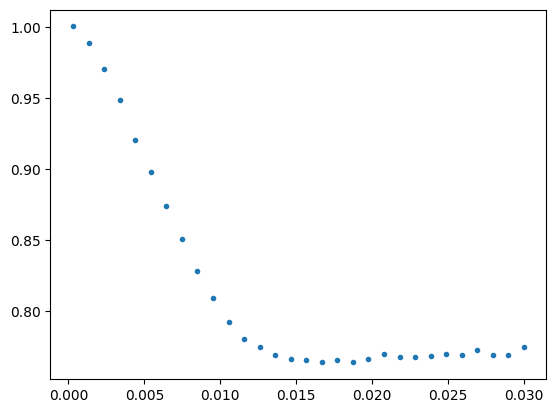

In [92]:
N = 30

B = np.zeros(N)
P = np.zeros(N)
dP = np.zeros(N)

t = -1
R = -1
for i in range(N):
    measurement = get_measurement_point(i, 'data_2a_20000')
    y_range=(-4,4)
    R, dR = measurement.rms_ratio(y_range)
    # print(R, dR)
    P[i] = R
    dP[i] = dR
    B[i] = float(measurement.parameters['By'])
# plt.errorbar(B,P, linestyle='-', yerr=dP)
plt.plot(B,P, '.')

/tmp/ipykernel_34933/1381604184.py:2: RuntimeWarning: invalid value encountered in divide
  P = (I_up - I_down) / (I_up + I_down)
/tmp/ipykernel_34933/1381604184.py:3: RuntimeWarning: invalid value encountered in divide
  dP = 2 * np.sqrt((I_down * dI_up)**2 + (I_up * dI_down)**2) / (I_up + I_down) ** 2


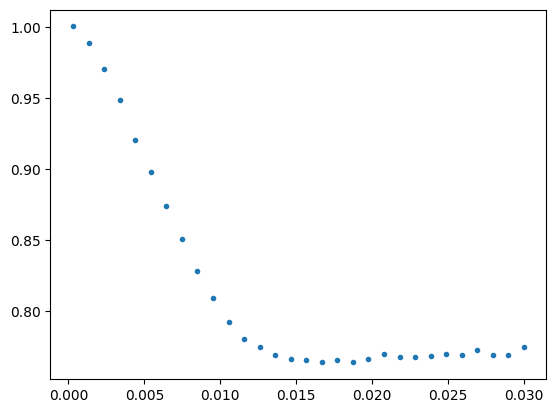

In [93]:
N = 30

B = np.zeros(N)
P = np.zeros(N)
dP = np.zeros(N)

t = -1
R = -1
for i in range(N):
    measurement = get_measurement_point(i, 'data_2a_20000')
    y_range=(-4,4)
    R, dR = measurement.rms_ratio(y_range)
    # print(R, dR)
    P[i] = R
    dP[i] = dR
    B[i] = float(measurement.parameters['By'])
# plt.errorbar(B,P, linestyle='-', yerr=dP)
plt.plot(B,P, '.')